# Cluster then Classify Experiments on Schelling-satisfaction

Test data were generated assuming a uniform(0,1) distribution for bias and 10,000 simulations were run.  At each timestep, the percent of agents satisfied with their location (satisfactions) is computed and saved.  Each simulation is run for 10 timesteps. 

In [1]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.clustering import silhouette_score
import seaborn as sns
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

2023-05-06 18:45:29.755932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
import random
random.seed(1)
os.environ['PYTHONHASHSEED']=str(1)

## Import simulation data - Schelling

In [3]:
os.chdir("/Users/maria/Desktop/Schelling_ML")
train_inputs = pd.read_csv('train_inputs_homo_0.csv')  
train_outputs = pd.read_csv('train_outputs_hap_0.csv')  
for i in range(1,100):
    filepath_in = 'train_inputs_homo_'+str(i)+'.csv'
    filepath_out = 'train_outputs_hap_'+str(i)+'.csv'
    file_in = pd.read_csv(filepath_in)
    file_out = pd.read_csv(filepath_out)
    train_inputs = pd.concat([train_inputs, file_in])
    train_outputs = pd.concat([train_outputs, file_out])

In [4]:
train_inputs = train_inputs*100
train_inputs

,0,1,2,3,4,5,6,7,8,9
0,51.32,54.18,59.42,63.98,67.72,77.22,82.76,85.60,88.88,92.84
1,49.02,49.18,49.18,49.18,49.18,49.18,49.18,49.18,49.18,49.18
2,49.94,52.52,54.04,58.36,64.88,69.86,76.96,81.12,85.32,85.38
3,50.16,57.92,66.42,73.32,79.80,86.46,89.78,93.52,94.94,95.30
4,50.12,51.54,51.78,51.78,51.78,51.78,51.78,51.78,51.78,51.78
...,...,...,...,...,...,...,...,...,...,...
95,49.66,59.88,69.62,79.84,85.30,88.32,89.84,90.02,91.68,92.26
96,49.58,50.14,50.38,50.38,50.38,50.38,50.38,50.38,50.38,50.38
97,48.98,61.28,68.82,76.26,82.22,84.70,85.76,87.00,87.20,87.18
98,50.70,53.44,57.74,60.20,64.84,74.74,75.84,80.34,85.00,92.44


## Determine k for the satisfaction vectors - elbow method

274.967 --> 195.659 --> 195.658 --> 195.658 --> 
156.201 --> 109.419 --> 102.703 --> 101.994 --> 101.967 --> 101.967 --> 101.967 --> 
112.069 --> 78.258 --> 76.345 --> 76.245 --> 76.243 --> 76.243 --> 
67.811 --> 45.441 --> 44.900 --> 44.865 --> 44.851 --> 44.850 --> 44.849 --> 44.849 --> 
54.377 --> 38.257 --> 37.600 --> 37.542 --> 37.524 --> 37.520 --> 37.519 --> 37.519 --> 37.519 --> 37.519 --> 37.519 --> 
50.805 --> 36.182 --> 35.919 --> 35.847 --> 35.783 --> 35.727 --> 35.715 --> 35.715 --> 35.715 --> 
43.507 --> 33.673 --> 33.353 --> 33.318 --> 33.309 --> 33.306 --> 33.306 --> 33.306 --> 33.306 --> 33.306 --> 33.306 --> 
36.909 --> 28.183 --> 27.889 --> 27.836 --> 27.811 --> 27.797 --> 27.790 --> 27.788 --> 27.787 --> 27.787 --> 27.787 --> 
32.896 --> 24.814 --> 24.264 --> 23.827 --> 23.338 --> 22.918 --> 22.688 --> 22.554 --> 22.490 --> 22.471 --> 22.466 --> 22.463 --> 22.459 --> 22.458 --> 22.457 --> 22.457 --> 22.457 --> 22.457 --> 22.457 --> 22.457 --> 22.457 --> 22.457 --> 2

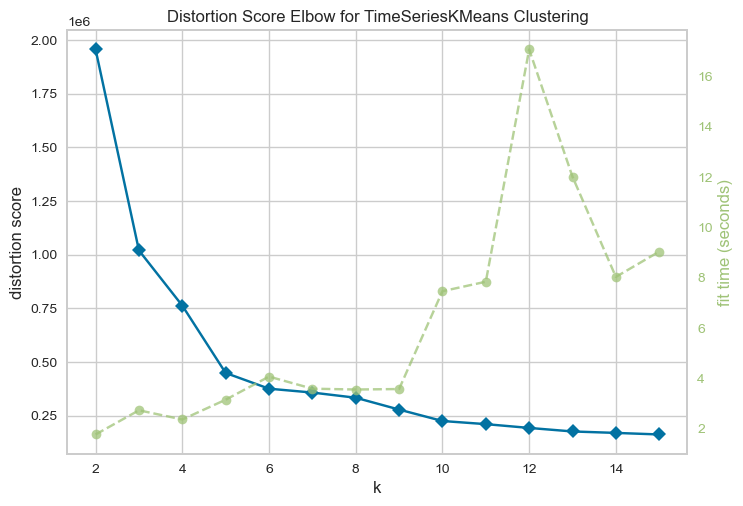

<Axes: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
seed=1
X_train = to_time_series_dataset(train_inputs)
X_train_flat = [xi.flatten() for xi in X_train]

km = TimeSeriesKMeans(verbose=True, random_state=seed)
visualizer = KElbowVisualizer(km, k=(2,16), locate_elbow=False)
 
visualizer.fit(np.array(X_train_flat))        
visualizer.show()   

## Cluster on satisfaction vectors - Euclidean k-means

67.811 --> 45.441 --> 44.900 --> 44.865 --> 44.851 --> 44.850 --> 44.849 --> 44.849 --> 


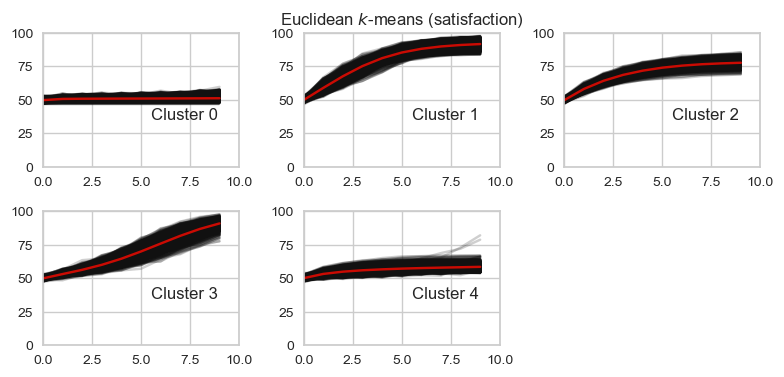

In [6]:
seed = 1
np.random.seed(seed)
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
plt.figure()
for yi in range(5):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 100)
    plt.text(0.55, 0.35,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means (satisfaction)")
        
plt.tight_layout()
#plt.savefig('schelling_satisfaction_ts.svg')
plt.show()

In [7]:
train_outputs['Euclidean_labels'] = y_pred
train_outputs.reset_index(drop=True)

,0,Euclidean_labels
0,0.652377,3
1,0.062143,0
2,0.674791,3
3,0.595799,1
4,0.143759,0
...,...,...
9995,0.414441,1
9996,0.119902,0
9997,0.438393,1
9998,0.698130,3


## Cluster on satisfaction vectors - Soft DTW k-means

3181.512 --> 727.689 --> 718.109 --> 730.568 --> 734.900 --> 741.625 --> 744.767 --> 743.572 --> 745.133 --> 744.173 --> 746.193 --> 744.529 --> 746.663 --> 744.851 --> 747.343 --> 746.212 --> 747.876 --> 747.591 --> 748.316 --> 747.743 --> 748.288 --> 747.741 --> 748.370 --> 747.820 --> 748.346 --> 747.891 --> 748.331 --> 747.947 --> 748.316 --> 747.996 --> 748.303 --> 748.042 --> 748.291 --> 748.701 --> 748.993 --> 749.705 --> 749.478 --> 750.030 --> 749.633 --> 750.037 --> 749.829 --> 750.055 --> 749.856 --> 750.028 --> 749.882 --> 750.023 --> 749.892 --> 750.010 --> 749.908 --> 750.004 --> 


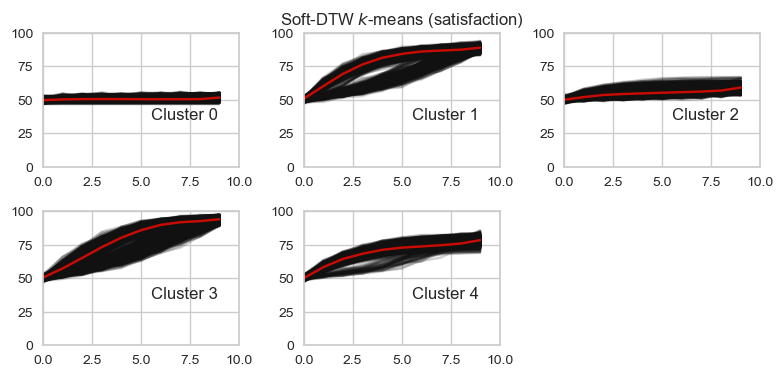

In [8]:
seed = 1
np.random.seed(seed)
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=seed, metric="softdtw")
y_pred = km.fit_predict(X_train)
plt.figure()
for yi in range(5):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 100)
    plt.text(0.55, 0.35,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means (satisfaction)")
        
plt.tight_layout()
#plt.savefig('schelling_satisfaction_ts.svg')
plt.show()

In [9]:
train_outputs['softDTW_labels'] = y_pred
train_outputs.reset_index(drop=True)
train_outputs.to_csv("Schelling_homogeneity_kmeans_5.csv")

## Mapping the cluster labels back to the inputs - KNN - Euclidean - satisfaction

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_outputs['0'].values.reshape(-1, 1), train_outputs['Euclidean_labels'], test_size=0.1, random_state = 1)

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [11]:
result = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(result)
report = classification_report(y_test, ypred)
print("Report:",)
print (report)
acc = accuracy_score(y_test,ypred)
print("Accuracy:",acc)

Confusion Matrix:
[[417   0   0   0  20]
 [  0 212   0   3   0]
 [  0   1  94   0   0]
 [  0   0   0 110   0]
 [ 33   0   0   1 109]]
Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       437
           1       1.00      0.99      0.99       215
           2       1.00      0.99      0.99        95
           3       0.96      1.00      0.98       110
           4       0.84      0.76      0.80       143

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Accuracy: 0.942


## Mapping the cluster labels back to the inputs - MLP - Euclidean - satisfaction

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
720/720 [==============================] - 2s 2ms/step - loss: 1.4623 - accuracy: 0.4404 - val_loss: 1.4184 - val_accuracy: 0.4489
Epoch 2/500
720/720 [==============================] - 1s 1ms/step - loss: 1.3749 - accuracy: 0.4761 - val_loss: 1.4128 - val_accuracy: 0.4489
Epoch 3/500
720/720 [==============================] - 1s 1ms/step - loss: 1.3686 - accuracy: 0.4761 - val_loss: 1.4076 - val_accuracy: 0.4489
Epoch 4/500
720/720 [======

Epoch 110/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2631 - accuracy: 0.9286 - val_loss: 0.2885 - val_accuracy: 0.9233
Epoch 111/500
720/720 [==============================] - 1s 2ms/step - loss: 0.2629 - accuracy: 0.9289 - val_loss: 0.2882 - val_accuracy: 0.9156
Epoch 112/500
720/720 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.9285 - val_loss: 0.2902 - val_accuracy: 0.9100
Epoch 113/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2617 - accuracy: 0.9290 - val_loss: 0.2877 - val_accuracy: 0.9139
Epoch 114/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2610 - accuracy: 0.9290 - val_loss: 0.2858 - val_accuracy: 0.9194
Epoch 115/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2606 - accuracy: 0.9299 - val_loss: 0.2889 - val_accuracy: 0.9133
Epoch 116/500
720/720 [==============================] - 1s 1ms/step - loss: 0.2602 - accuracy: 0.9296 - val_loss: 0.2868 - val_ac

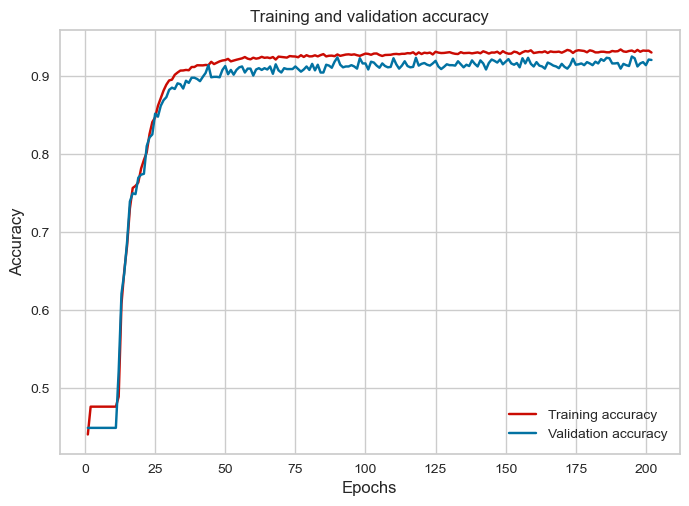

In [12]:
X = X_train
Y = y_train
dummy_y = np_utils.to_categorical(Y)

model = Sequential()
model.add(Dense(8, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True)

history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

preds = model.predict(X) 
print(preds[0]) 
print(np.sum(preds[0])) 

matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

In [13]:
preds = model.predict(X_test) 
print("Report:",)
print(classification_report(y_test, preds.argmax(axis=1)))
acc = accuracy_score(y_test,preds.argmax(axis=1))
print("Accuracy:",acc)

32/32 [==============================] - 0s 999us/step
Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       437
           1       0.99      0.98      0.98       215
           2       0.99      0.99      0.99        95
           3       0.81      0.98      0.89       110
           4       0.92      0.68      0.78       143

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.93      0.92      0.92      1000

Accuracy: 0.924


## Mapping the cluster labels back to the inputs - KNN - soft-DTW - satisfaction

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_outputs['0'].values.reshape(-1, 1), train_outputs['softDTW_labels'], test_size=0.1, random_state = 1)

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#print(sorted(Counter(y_resampled).items()))

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [15]:
result = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(result)
report = classification_report(y_test, ypred)
print("Report:",)
print (report)
acc = accuracy_score(y_test,ypred)
print("Accuracy:",acc)

Confusion Matrix:
[[382   0  30   0   0]
 [  0 112   0  30   2]
 [ 27   0 140   0   0]
 [  0  31   0 147   0]
 [  0   5   0   2  92]]
Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       412
           1       0.76      0.78      0.77       144
           2       0.82      0.84      0.83       167
           3       0.82      0.83      0.82       178
           4       0.98      0.93      0.95        99

    accuracy                           0.87      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.87      0.87      0.87      1000

Accuracy: 0.873


## Mapping the cluster labels back to the inputs - MLP - soft-DTW - satisfaction

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
720/720 [==============================] - 2s 2ms/step - loss: 1.4965 - accuracy: 0.4090 - val_loss: 1.4499 - val_accuracy: 0.4306
Epoch 2/500
720/720 [==============================] - 1s 1ms/step - loss: 1.4224 - accuracy: 0.4472 - val_loss: 1.4346 - val_accuracy: 0.4306
Epoch 3/500
720/720 [==============================] - 1s 1ms/step - loss: 1.4042 - accuracy: 0.4472 - val_loss: 1.4143 - val_accuracy: 0.4306
Epoch 4/500
720/720 [====

Epoch 110/500
720/720 [==============================] - 1s 2ms/step - loss: 0.4442 - accuracy: 0.8601 - val_loss: 0.4483 - val_accuracy: 0.8283
Epoch 111/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4446 - accuracy: 0.8579 - val_loss: 0.4471 - val_accuracy: 0.8339
Epoch 112/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4436 - accuracy: 0.8508 - val_loss: 0.4459 - val_accuracy: 0.8678
Epoch 113/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4436 - accuracy: 0.8564 - val_loss: 0.4446 - val_accuracy: 0.8600
Epoch 114/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4433 - accuracy: 0.8582 - val_loss: 0.4442 - val_accuracy: 0.8489
Epoch 115/500
720/720 [==============================] - 1s 1ms/step - loss: 0.4430 - accuracy: 0.8557 - val_loss: 0.4444 - val_accuracy: 0.8483
Epoch 116/500
720/720 [==============================] - 1s 2ms/step - loss: 0.4423 - accuracy: 0.8590 - val_loss: 0.4431 - val_ac

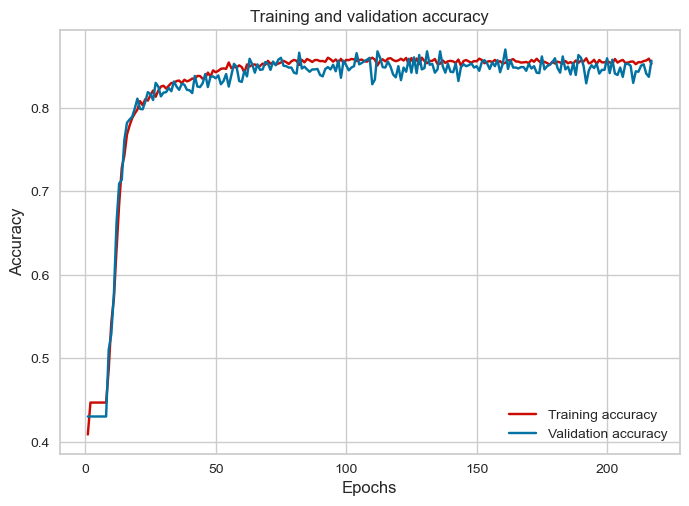

In [16]:
X = X_train
Y = y_train
dummy_y = np_utils.to_categorical(Y)

model = Sequential()
model.add(Dense(8, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True)

history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

preds = model.predict(X) 
print(preds[0]) 
print(np.sum(preds[0])) 

matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

In [17]:
preds = model.predict(X_test) 
print("Report:",)
print(classification_report(y_test, preds.argmax(axis=1)))
acc = accuracy_score(y_test,preds.argmax(axis=1))
print("Accuracy:",acc)

32/32 [==============================] - 0s 1ms/step
Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       412
           1       0.75      0.70      0.73       144
           2       0.89      0.80      0.84       167
           3       0.73      0.81      0.77       178
           4       0.98      0.93      0.95        99

    accuracy                           0.86      1000
   macro avg       0.85      0.84      0.85      1000
weighted avg       0.87      0.86      0.86      1000

Accuracy: 0.863


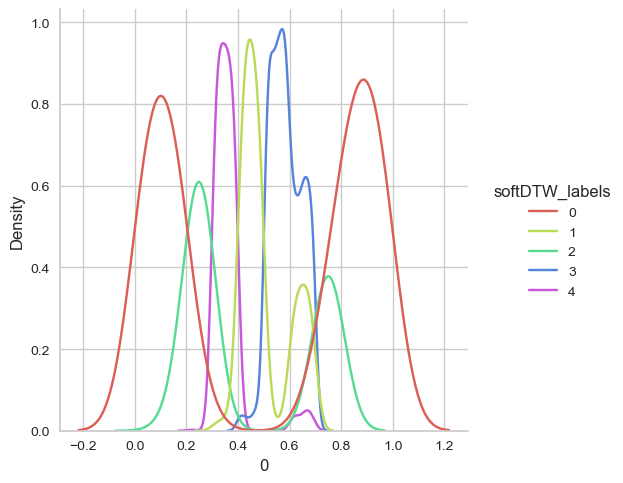

In [18]:
plt = sns.displot(data=train_outputs.reset_index(drop=True), x='0', hue="softDTW_labels", kind="kde", palette=sns.color_palette("hls", 5))

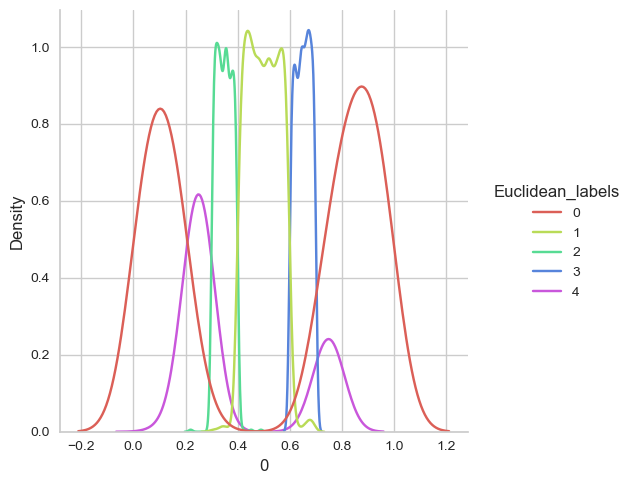

In [19]:
plt = sns.displot(data=train_outputs.reset_index(drop=True), x='0', hue="Euclidean_labels", kind="kde", palette=sns.color_palette("hls", 5))